In [1]:
# Nhập thư viện
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import time

import warnings
warnings.filterwarnings('ignore')

# Đọc bộ dữ liệu
corpus = pd.read_csv('data/cleaned_mhc.csv')

# Chuẩn bị dữ liệu
X_train, X_test, y_train, y_test = train_test_split(
    corpus['text'],
    corpus['label'],
    test_size=0.2,
    random_state=42
)

from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(max_features=3500)

X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

binary_vectorizer = CountVectorizer(binary=True, max_features=3500)

X_train_bin = binary_vectorizer.fit_transform(X_train)
X_test_bin = binary_vectorizer.transform(X_test)

tfidf = TfidfVectorizer(max_features=3500)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

n_components = 100

lsa = TruncatedSVD(n_components=n_components, random_state=42)
X_train_lsa = lsa.fit_transform(X_train_tfidf)
X_test_lsa = lsa.transform(X_test_tfidf)

print(f"BOW - Train shape: {X_train_bow.shape}, Test Shape: {X_test_bow.shape}")
print(f"Binary - Train shape: {X_train_bin.shape}, Test Shape: {X_test_bin.shape}")
print(f"TF-IDF - Train shape: {X_train_tfidf.shape}, Test Shape: {X_test_tfidf.shape}")
print(f"LSA - Train shape: {X_train_lsa.shape}, Test Shape: {X_test_lsa.shape}")

BOW - Train shape: (18592, 3500), Test Shape: (4648, 3500)
Binary - Train shape: (18592, 3500), Test Shape: (4648, 3500)
TF-IDF - Train shape: (18592, 3500), Test Shape: (4648, 3500)
LSA - Train shape: (18592, 100), Test Shape: (4648, 100)


Multinomial NB (BOW) Evaluation:
Train Accuracy: 0.8784423407917383
Test Accuracy: 0.8769363166953529
F1 Score: 0.8746847915874123
Precision: 0.8886851054447634
Recall: 0.8769363166953529
Confusion Matrix:
 [[1597  502]
 [  70 2479]]
----------------------------------------
Bernoulli NB (Binary) Evaluation:
Train Accuracy: 0.8061531841652324
Test Accuracy: 0.8089500860585198
F1 Score: 0.8085201402311936
Precision: 0.8303208387850348
Recall: 0.8089500860585198
Confusion Matrix:
 [[1925  174]
 [ 714 1835]]
----------------------------------------
Gaussian NB (TF-IDF) Evaluation:
Train Accuracy: 0.8586488812392427
Test Accuracy: 0.8362736660929432
F1 Score: 0.833537246692415
Precision: 0.844413171088011
Recall: 0.8362736660929432
Confusion Matrix:
 [[1515  584]
 [ 177 2372]]
----------------------------------------
Gaussian NB (LSA) Evaluation:
Train Accuracy: 0.7777000860585198
Test Accuracy: 0.7773235800344234
F1 Score: 0.7767417965054518
Precision: 0.7769021503398635
Recall: 0.77732358

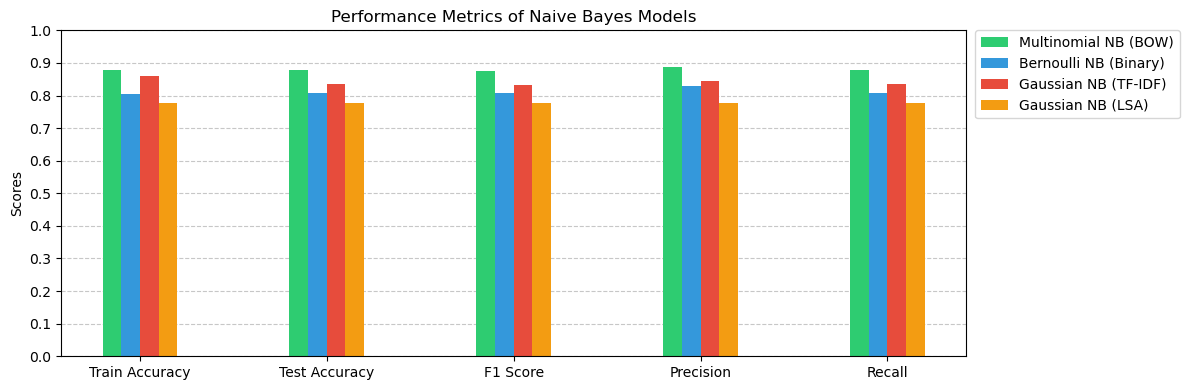

In [2]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB

# Multinomial NB on BOW dataset
multinomial_nb = MultinomialNB()
multinomial_nb.fit(X_train_bow, y_train)
mnb_train_pred = multinomial_nb.predict(X_train_bow)
mnb_test_pred = multinomial_nb.predict(X_test_bow)

# Bernoulli NB on Binary dataset
bernoulli_nb = BernoulliNB()
bernoulli_nb.fit(X_train_bin, y_train)
bnb_train_pred = bernoulli_nb.predict(X_train_bin)
bnb_test_pred = bernoulli_nb.predict(X_test_bin)

# Gaussian NB on TF-IDF dataset
gaussian_nb_tfidf = GaussianNB()
X_train_tfidf_dense = X_train_tfidf.toarray()
X_test_tfidf_dense = X_test_tfidf.toarray()
gaussian_nb_tfidf.fit(X_train_tfidf_dense, y_train)
gnb_tfidf_train_pred = gaussian_nb_tfidf.predict(X_train_tfidf_dense)
gnb_tfidf_test_pred = gaussian_nb_tfidf.predict(X_test_tfidf_dense)

# Gaussian NB on LSA dataset
gaussian_nb_lsa = GaussianNB()
gaussian_nb_lsa.fit(X_train_lsa, y_train)
gnb_lsa_train_pred = gaussian_nb_lsa.predict(X_train_lsa)
gnb_lsa_test_pred = gaussian_nb_lsa.predict(X_test_lsa)

# Helper function for metrics
def evaluate_model(y_true_train, y_pred_train, y_true_test, y_pred_test, model_name):
    metrics = {
        "Train Accuracy": accuracy_score(y_true_train, y_pred_train),
        "Test Accuracy": accuracy_score(y_true_test, y_pred_test),
        "F1 Score": f1_score(y_true_test, y_pred_test, average='weighted'),
        "Precision": precision_score(y_true_test, y_pred_test, average='weighted'),
        "Recall": recall_score(y_true_test, y_pred_test, average='weighted')
    }
    print(f"{model_name} Evaluation:")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")
    print("Confusion Matrix:\n", confusion_matrix(y_true_test, y_pred_test))
    print("-" * 40)
    return metrics

# Evaluate all models
metrics_mnb = evaluate_model(y_train, mnb_train_pred, y_test, mnb_test_pred, "Multinomial NB (BOW)")
metrics_bnb = evaluate_model(y_train, bnb_train_pred, y_test, bnb_test_pred, "Bernoulli NB (Binary)")
metrics_gnb_tfidf = evaluate_model(y_train, gnb_tfidf_train_pred, y_test, gnb_tfidf_test_pred, "Gaussian NB (TF-IDF)")
metrics_gnb_lsa = evaluate_model(y_train, gnb_lsa_train_pred, y_test, gnb_lsa_test_pred, "Gaussian NB (LSA)")

# Plot performance metrics with improved styling
labels = ["Train Accuracy", "Test Accuracy", "F1 Score", "Precision", "Recall"]
model_names = ["Multinomial NB (BOW)", "Bernoulli NB (Binary)", "Gaussian NB (TF-IDF)", "Gaussian NB (LSA)"]
metrics_list = [
    list(metrics_mnb.values()),
    list(metrics_bnb.values()),
    list(metrics_gnb_tfidf.values()),
    list(metrics_gnb_lsa.values())
]

x = np.arange(len(labels))  # Label locations
width = 0.1  # Reduced width of bars (previously 0.2)

# Create figure with a larger size and better aspect ratio
fig, ax = plt.subplots(figsize=(12, 4))

# Plot bars with different colors using a professional color palette
colors = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12']
for i, (metrics, model_name) in enumerate(zip(metrics_list, model_names)):
    ax.bar(x + i * width, metrics, width, label=model_name, color=colors[i])

# Customize the plot
ax.set_ylabel("Scores")
ax.set_title("Performance Metrics of Naive Bayes Models")

# Position x-axis labels
ax.set_xticks(x + width * (len(model_names) - 1) / 2)
ax.set_xticklabels(labels)

# Add gridlines
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)  # Put gridlines behind bars

# Customize y-axis
ax.set_ylim(0, 1.0)  # Set y-axis limits
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))  # More bins (every 0.05)

# Move legend outside of plot
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()